# Project 1: News Classification with FFN, RNN, and LSTM

**Name:** Peyton Campbell 
**Student No.** 1316136
**Course:** INFO 6153
**Due Date:** June 13, 2025

---

##  Dataset
- **Name:** AG News
- **Task:** News headline classification (4 categories)
- **Input:** News headline (text)
- **Output:** Category (World, Sports, Business, Sci/Tech)

---

##  Experiment Setup

- **Embedding Dim:** 128  
- **Max Length:** 128 tokens  
- **Batch Size:** 32  
- **Epochs:** 5  
- **Optimizer:** Adam (lr=0.001)  
- **Loss:** CrossEntropy  
- **Metric:** Accuracy  

---

##  Models & Parameter Counts

| Model      | Parameters   |
|------------|--------------|
| FFN        | *6,004,612*  |
| Simple RNN | *3,940,356*  |
| LSTM       | *4,039,428*  |

---

##  Results Overview

| Model      | Final Accuracy |
|------------|----------------|
| FFN        | 89%          |
| Simple RNN | 25%          |
| LSTM       | 91%          |

---

##  Training Curves

Each model includes:
- **Training Loss**
- **Validation Accuracy**
- **Gradient Norm**

---

##  Conclusion

- **LSTM** achieved the highest accuracy at **91%**, effectively modeling the sequential structure of the text.
- **FFN** followed closely with **89% accuracy**, which is notable considering its simpler architecture and faster training time.
- **Simple RNN** significantly underperformed with just **25% accuracy**, highlighting its limitations in handling longer sequences or retaining information across time steps.

 **Key Takeaway:**
- LSTM is the most robust architecture for text classification among the three, benefiting from its memory cell design.
- FFN surprisingly performed well, likely due to the strong signal in the AG News dataset and efficient word-level representation.
- Simple RNN struggled to converge and appears insufficient for this task without additional tuning or enhancements.

Overall, **LSTM is recommended for sequence tasks**, while **FFN may serve as a strong baseline when computational resources are limited**.

In [2]:
from datasets import load_dataset
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer
import torch
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np

In [3]:
# AG News Classification with FFN, RNN, and LSTM

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer
from datasets import load_dataset
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
MAX_LEN = 128
BATCH_SIZE = 32
HIDDEN_DIM = 128
NUM_EPOCHS = 5
NUM_CLASSES = 4

# Load and split dataset
ds = load_dataset("ag_news")
texts = ds['train']['text']
labels = ds['train']['label']
train_texts, val_texts, train_labels, val_labels = train_test_split(texts, labels, test_size=0.1, random_state=42)

# Tokenizer
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
VOCAB_SIZE = tokenizer.vocab_size

# Dataset class
class NewsDataset(Dataset):
    def __init__(self, texts, labels):
        self.encodings = tokenizer(texts, truncation=True, padding="max_length", max_length=MAX_LEN)
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            'input_ids': torch.tensor(self.encodings['input_ids'][idx]),
            'attention_mask': torch.tensor(self.encodings['attention_mask'][idx]),
            'labels': torch.tensor(self.labels[idx])
        }

# DataLoaders
train_dataset = NewsDataset(train_texts, train_labels)
val_dataset = NewsDataset(val_texts, val_labels)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)

# Model definitions
class FFNClassifier(nn.Module):
    def __init__(self, vocab_size):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, HIDDEN_DIM)
        self.fc1 = nn.Linear(HIDDEN_DIM * MAX_LEN, HIDDEN_DIM)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(HIDDEN_DIM, NUM_CLASSES)

    def forward(self, x):
        x = self.embedding(x)
        x = x.view(x.size(0), -1)
        x = self.relu(self.fc1(x))
        return self.fc2(x)

class RNNClassifier(nn.Module):
    def __init__(self, vocab_size):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, HIDDEN_DIM)
        self.rnn = nn.RNN(HIDDEN_DIM, HIDDEN_DIM, batch_first=True)
        self.fc = nn.Linear(HIDDEN_DIM, NUM_CLASSES)

    def forward(self, x):
        x = self.embedding(x)
        _, h_n = self.rnn(x)
        return self.fc(h_n.squeeze(0))

class LSTMClassifier(nn.Module):
    def __init__(self, vocab_size):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, HIDDEN_DIM)
        self.lstm = nn.LSTM(HIDDEN_DIM, HIDDEN_DIM, batch_first=True)
        self.fc = nn.Linear(HIDDEN_DIM, NUM_CLASSES)

    def forward(self, x):
        x = self.embedding(x)
        _, (h_n, _) = self.lstm(x)
        return self.fc(h_n.squeeze(0))

In [7]:
# Training and evaluation functions
def train_model(model, train_loader, val_loader, num_epochs=5, learning_rate=1e-3):
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    train_losses, val_accuracies, gradient_norms = [], [], []

    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0
        grad_norm_epoch = 0

        for batch in train_loader:
            inputs = batch['input_ids'].to(device)
            labels = batch['labels'].to(device)

            optimizer.zero_grad()
            outputs = model(inputs)

            loss = criterion(outputs, labels)
            loss.backward()

            # Gradient norm
            total_norm = 0
            for p in model.parameters():
                if p.grad is not None:
                    param_norm = p.grad.data.norm(2)
                    total_norm += param_norm.item() ** 2
            total_norm = total_norm ** 0.5
            grad_norm_epoch += total_norm

            optimizer.step()
            epoch_loss += loss.item()

        avg_loss = epoch_loss / len(train_loader)
        avg_grad_norm = grad_norm_epoch / len(train_loader)
        val_acc = evaluate_model(model, val_loader)

        train_losses.append(avg_loss)
        val_accuracies.append(val_acc)
        gradient_norms.append(avg_grad_norm)

        print(f"Epoch {epoch+1}/{num_epochs} - Loss: {avg_loss:.4f}, Val Accuracy: {val_acc:.4f}, Grad Norm: {avg_grad_norm:.4f}")

    return train_losses, val_accuracies, gradient_norms

def evaluate_model(model, loader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for batch in loader:
            inputs = batch['input_ids'].to(device)
            labels = batch['labels'].to(device)
            outputs = model(inputs)
            predictions = torch.argmax(outputs, dim=1)
            correct += (predictions == labels).sum().item()
            total += labels.size(0)
    return correct / total

def plot_training_metrics(losses, accuracies, grad_norms, title_prefix="Model"):
    epochs = list(range(1, len(losses) + 1))

    plt.figure()
    plt.plot(epochs, losses, label='Training Loss')
    plt.title(f'{title_prefix} - Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig(f"{title_prefix}_Loss.png")

    plt.figure()
    plt.plot(epochs, accuracies, label='Validation Accuracy')
    plt.title(f'{title_prefix} - Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.savefig(f"{title_prefix}_Accuracy.png")

    plt.figure()
    plt.plot(epochs, grad_norms, label='Gradient Norm')
    plt.title(f'{title_prefix} - Gradient Norm')
    plt.xlabel('Epoch')
    plt.ylabel('Norm')
    plt.legend()
    plt.savefig(f"{title_prefix}_GradNorm.png")

Epoch 1/5 - Loss: 0.6002, Val Accuracy: 0.8777, Grad Norm: 3.8680
Epoch 2/5 - Loss: 0.2462, Val Accuracy: 0.8963, Grad Norm: 2.3030
Epoch 3/5 - Loss: 0.1583, Val Accuracy: 0.8942, Grad Norm: 1.7990
Epoch 4/5 - Loss: 0.0948, Val Accuracy: 0.8893, Grad Norm: 1.3286
Epoch 5/5 - Loss: 0.0522, Val Accuracy: 0.8861, Grad Norm: 0.9163


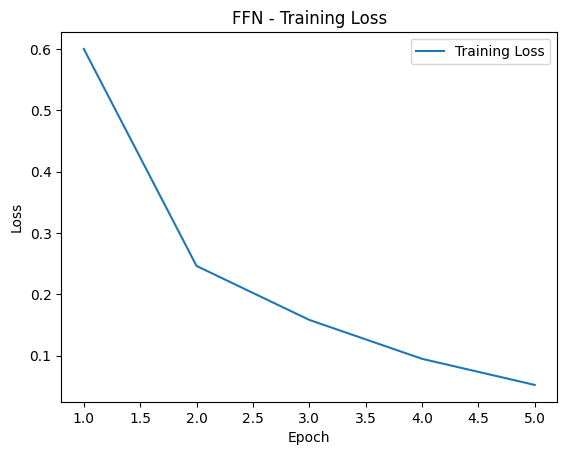

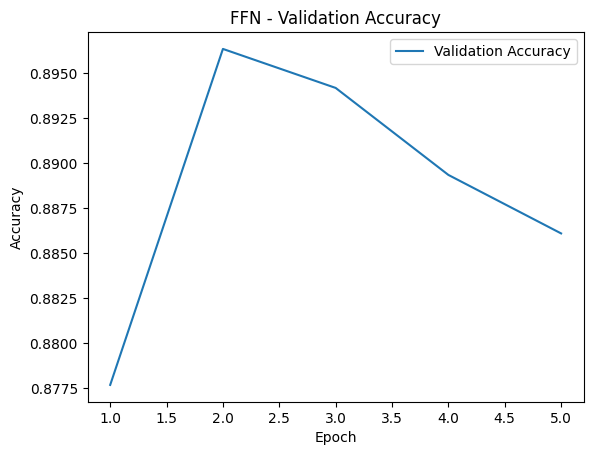

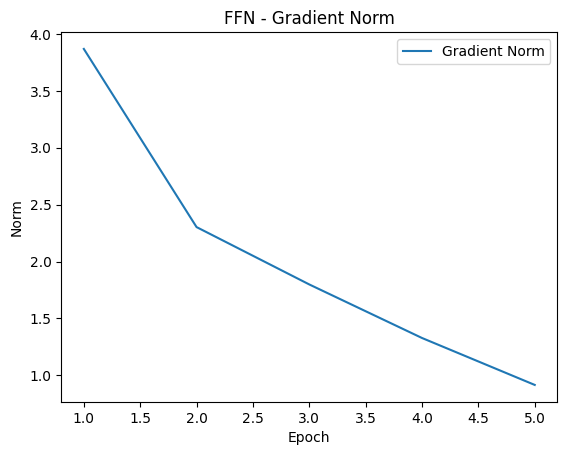

Epoch 1/5 - Loss: 1.3915, Val Accuracy: 0.2563, Grad Norm: 1.2869
Epoch 2/5 - Loss: 1.3915, Val Accuracy: 0.2529, Grad Norm: 1.6232
Epoch 3/5 - Loss: 1.3918, Val Accuracy: 0.2509, Grad Norm: 1.7204
Epoch 4/5 - Loss: 1.3912, Val Accuracy: 0.2512, Grad Norm: 1.6765
Epoch 5/5 - Loss: 1.3923, Val Accuracy: 0.2509, Grad Norm: 1.7281


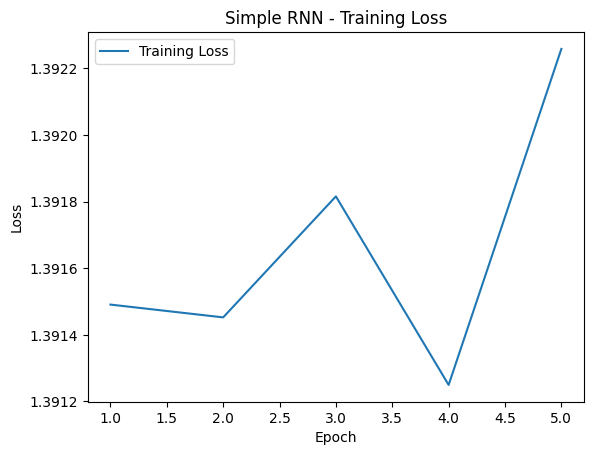

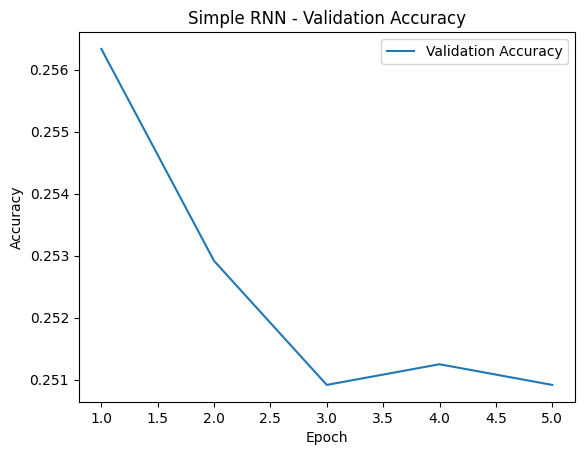

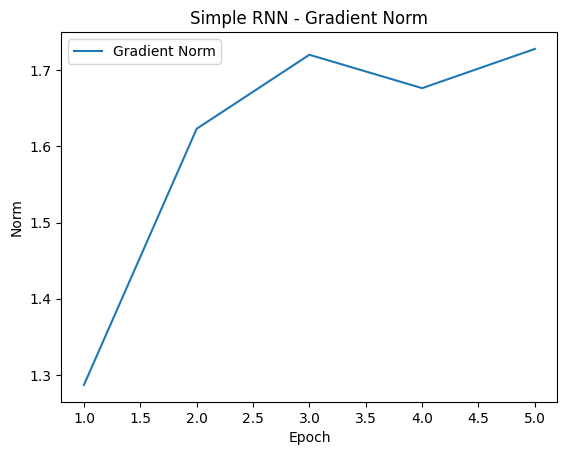

Epoch 1/5 - Loss: 0.6914, Val Accuracy: 0.8848, Grad Norm: 1.3532
Epoch 2/5 - Loss: 0.2826, Val Accuracy: 0.9037, Grad Norm: 1.0512
Epoch 3/5 - Loss: 0.2068, Val Accuracy: 0.9120, Grad Norm: 0.8530
Epoch 4/5 - Loss: 0.1541, Val Accuracy: 0.9131, Grad Norm: 0.7649
Epoch 5/5 - Loss: 0.1129, Val Accuracy: 0.9154, Grad Norm: 0.7082


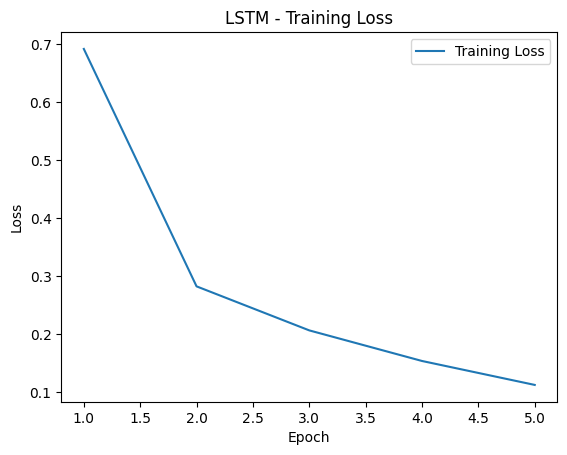

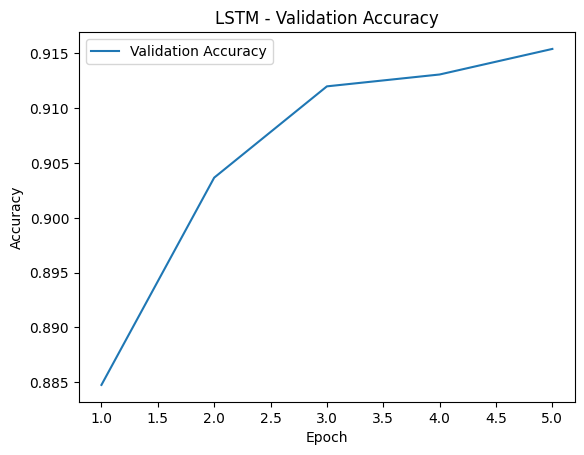

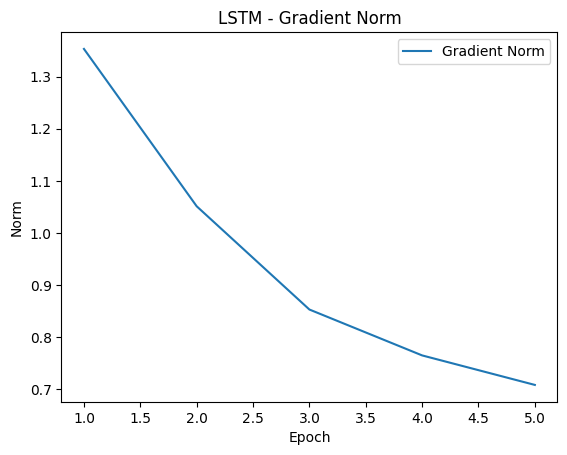

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vocab_size = tokenizer.vocab_size
hidden_dim = 128

# Run all models
model_ffn = FFNClassifier(VOCAB_SIZE)
losses_ffn, accs_ffn, grads_ffn = train_model(model_ffn, train_loader, val_loader, num_epochs=NUM_EPOCHS)
plot_training_metrics(losses_ffn, accs_ffn, grads_ffn, title_prefix="FFN")

model_rnn = RNNClassifier(VOCAB_SIZE)
losses_rnn, accs_rnn, grads_rnn = train_model(model_rnn, train_loader, val_loader, num_epochs=NUM_EPOCHS)
plot_training_metrics(losses_rnn, accs_rnn, grads_rnn, title_prefix="Simple RNN")

model_lstm = LSTMClassifier(VOCAB_SIZE)
losses_lstm, accs_lstm, grads_lstm = train_model(model_lstm, train_loader, val_loader, num_epochs=NUM_EPOCHS)
plot_training_metrics(losses_lstm, accs_lstm, grads_lstm, title_prefix="LSTM")

In [9]:
def print_model_info(model, name):
    print(f"\n{name} Summary")
    print(model)
    total_params = sum(p.numel() for p in model.parameters())
    print(f"Total Parameters: {total_params:,}")

print_model_info(model_ffn, "FFN Classifier")
print_model_info(model_rnn, "Simple RNN Classifier")
print_model_info(model_lstm, "LSTM Classifier")


FFN Classifier Summary
FFNClassifier(
  (embedding): Embedding(30522, 128)
  (fc1): Linear(in_features=16384, out_features=128, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=128, out_features=4, bias=True)
)
Total Parameters: 6,004,612

Simple RNN Classifier Summary
RNNClassifier(
  (embedding): Embedding(30522, 128)
  (rnn): RNN(128, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=4, bias=True)
)
Total Parameters: 3,940,356

LSTM Classifier Summary
LSTMClassifier(
  (embedding): Embedding(30522, 128)
  (lstm): LSTM(128, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=4, bias=True)
)
Total Parameters: 4,039,428
